In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import torch
from matplotlib import pyplot as plt
from in_progress.regularizers import LieDerivativeRegularizer, CurvatureRegularizer
from torch import Tensor
from in_progress.utils.ring_attractor_data import data_gen
from hydra import compose, initialize
from in_progress.test_dynamics import WarpedRingAttractorRNN, RNNToODE, PerturbedRingAttractorRNN # noqa
import numpy as np
from functools import partial
import pytorch_lightning as pl
from math import ceil

from hydra.core.global_hydra import GlobalHydra

if GlobalHydra.instance().is_initialized():
    GlobalHydra.instance().clear()
initialize(version_base=None, config_path='.', job_name="lds")
cfg = compose(config_name="config")
DEBUG = True

n_trials, n_neurons, n_time_bins = 300, 100, 75


def v(x: Tensor) -> Tensor:
    return x @ torch.tensor([[0.0, -1.0], [1.0, 0.0]])
bin_sz = 1e-2  # small values c.a. 1e-1 make the system diverge

_regularizer_list = []
_regularizer_list.append(partial(CurvatureRegularizer, order=1))
_regularizer_list.append(partial(LieDerivativeRegularizer, g=v, normalize=False))
_regularizer_list.append(partial(LieDerivativeRegularizer, g=v, normalize="yang"))
_regularizer_list.append(partial(LieDerivativeRegularizer, g=v, normalize="new"))
r_at_perturbation_magnitudes = []


### Perturbed Ring Attractor RNN

In [2]:
_bin_sz = 1e-1  # small values c.a. 1e-1 make the system diverge
_n_time_bins = ceil(7.5 / bin_sz)
_n_trials = 200

In [3]:
perturbation_magnitudes = np.geomspace(1e-3, 2, num=10)

r_at_perturbation_magnitudes = []
for i, _var in enumerate(perturbation_magnitudes):
    pl.seed_everything(cfg.seed, workers=True, verbose=False)
    kw = data_gen(n_neurons, _n_time_bins, _n_trials, _bin_sz, rnn_kwargs={'perturbation_magnitude': _var, 'dynamics':PerturbedRingAttractorRNN}, cfg=cfg)
    z = kw['z_train']

    mean_fn = kw['mean_fn']
    mean_fn = RNNToODE(mean_fn)
    regularizer_vals = []
    vals = []
    for regfcn in _regularizer_list:
        regularizer = regfcn(mean_fn)
        pts = z
        # pts1 = mean_fn._wrapped._wrapped.phi_inverse(pts1)
        vals = regularizer.eval_regularizer(pts).mean()
        regularizer_vals.append(vals)
    r_at_perturbation_magnitudes.append(torch.stack(regularizer_vals, dim=-1))
r_at_perturbation_magnitudes = torch.stack(r_at_perturbation_magnitudes, dim=0).cpu().detach().numpy()

/opt/homebrew/Caskroom/miniforge/base/envs/xfads/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


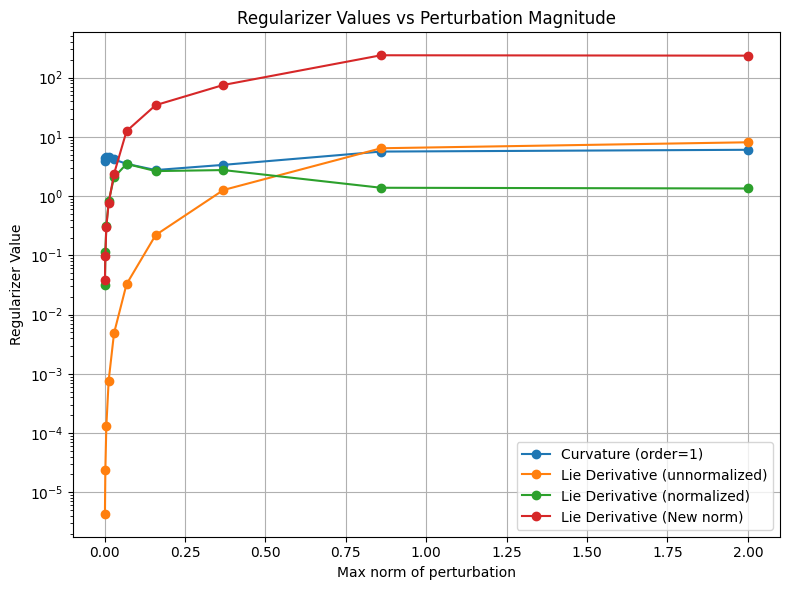

In [4]:
regularizer_labels = [
    "Curvature (order=1)",
    "Lie Derivative (unnormalized)",
    "Lie Derivative (normalized)",
    "Lie Derivative (New norm)"
]

# Plot

plt.figure(figsize=(8, 6))
for i in range(len(regularizer_labels)):
    plt.plot(perturbation_magnitudes, r_at_perturbation_magnitudes[:, i], marker='o', label=regularizer_labels[i])

plt.xlabel("Max norm of perturbation")
plt.ylabel("Regularizer Value")
plt.title("Regularizer Values vs Perturbation Magnitude")
plt.legend()
plt.grid(True)
plt.yscale("log")
# plt.xscale("log")
plt.tight_layout()
plt.savefig("regularizer_vs_perturbation.png", dpi=300, bbox_inches="tight")
plt.show()

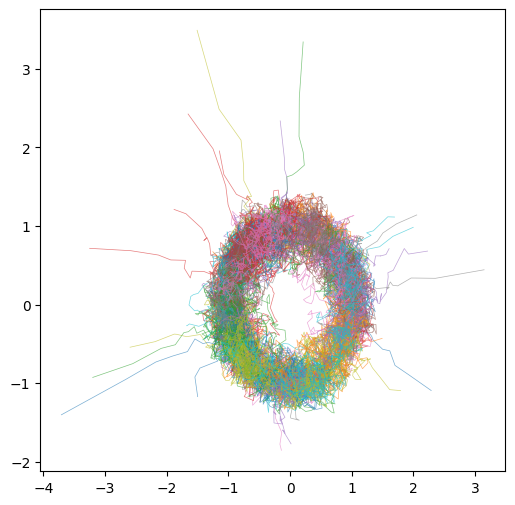

In [5]:
kw = data_gen(n_neurons, _n_time_bins, n_trials, _bin_sz, rnn_kwargs={'perturbation_magnitude': perturbation_magnitudes[0], 'dynamics':PerturbedRingAttractorRNN}, cfg=cfg)
z = kw['z_train']

fig, axs = plt.subplots(figsize=(6, 6))
for i in range(40):
    axs.plot(z[i, :, 0].cpu(), z[i, :, 1].cpu(), alpha=0.6, linewidth=0.5)

### Warped Ring Attractor RNN

In [6]:
_bin_sz = 1e-1  # small values c.a. 1e-1 make the system diverge
_n_time_bins = ceil(7.5 / bin_sz)
_n_trials = 200 # Reduce number of trials for faster computation

In [8]:
perturbation_magnitudes = np.geomspace(0.1, 20, num=10)

r_at_perturbation_magnitudes = []
for i, _var in enumerate(perturbation_magnitudes):
    pl.seed_everything(cfg.seed, workers=True, verbose=False)
    kw = data_gen(n_neurons, _n_time_bins, _n_trials, _bin_sz, rnn_kwargs={'t_conj':_var}, cfg=cfg)
    z = kw['z_train']

    mean_fn = kw['mean_fn']
    mean_fn = RNNToODE(mean_fn)
    regularizer_vals = []
    for regfcn in _regularizer_list:
        regularizer = regfcn(mean_fn)
        pts = z[:10,...].clone() if DEBUG else z
        # pts1 = mean_fn._wrapped._wrapped.phi_inverse(pts1)
        vals = regularizer.eval_regularizer(pts).mean()
        regularizer_vals.append(vals)
    r_at_perturbation_magnitudes.append(torch.stack(regularizer_vals, dim=-1))
r_at_perturbation_magnitudes = torch.stack(r_at_perturbation_magnitudes, dim=0).cpu().detach().numpy()

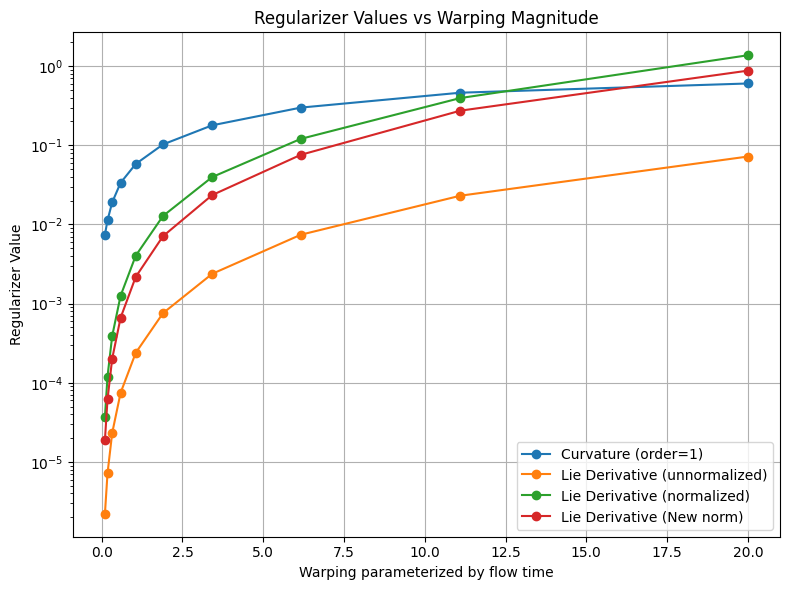

In [9]:
regularizer_labels = [
    "Curvature (order=1)",
    "Lie Derivative (unnormalized)",
    "Lie Derivative (normalized)",
    "Lie Derivative (New norm)"
]

# Plot

plt.figure(figsize=(8, 6))
for i in range(len(regularizer_labels)):
    plt.plot(perturbation_magnitudes, r_at_perturbation_magnitudes[:, i], marker='o', label=regularizer_labels[i])

plt.xlabel("Warping parameterized by flow time")
plt.ylabel("Regularizer Value")
plt.title("Regularizer Values vs Warping Magnitude")
plt.legend()
plt.grid(True)
plt.yscale("log")
# plt.xscale("log")
plt.tight_layout()
plt.savefig("regularizer_vs_warping.png", dpi=300, bbox_inches="tight")
plt.show()

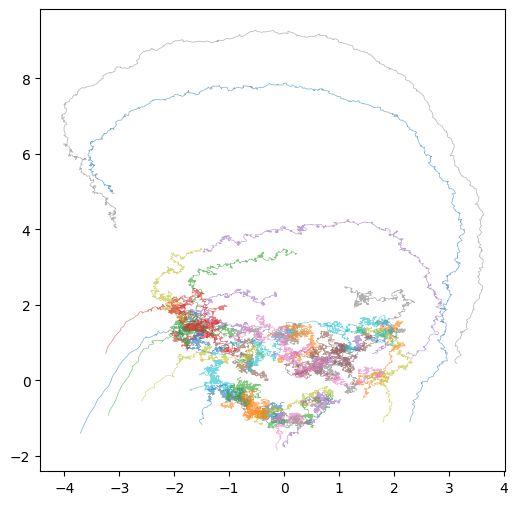

In [10]:
kw = data_gen(n_neurons, _n_time_bins, _n_trials, bin_sz, rnn_kwargs={'t_conj' : perturbation_magnitudes[-1]}, cfg=cfg)
z = kw['z_train']

fig, axs = plt.subplots(figsize=(6, 6))
for i in range(40):
    axs.plot(z[i, :, 0].cpu(), z[i, :, 1].cpu(), alpha=0.6, linewidth=0.5)